In [120]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
import arviz as az
import pymc as pm
import seaborn as sns

from REStats.utils import load_SCADA, transform, inv_transform
from REStats.models import fit_weibull

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
import statsmodels.api as sm

In [121]:
# cmap = mpl.colormaps['tab10']
sns.set_theme()

In [122]:
wt = load_SCADA(2020)

# Wind -> Wind

This approach takes advantage of the fact that wind speeds follow a Weibull distribution. By fitting the curve to find the shape $\alpha$ and scale $\beta$ parameters, we can apply a transformation to make the curve more Gaussian, after which we can standardize the data before passing it to the model.

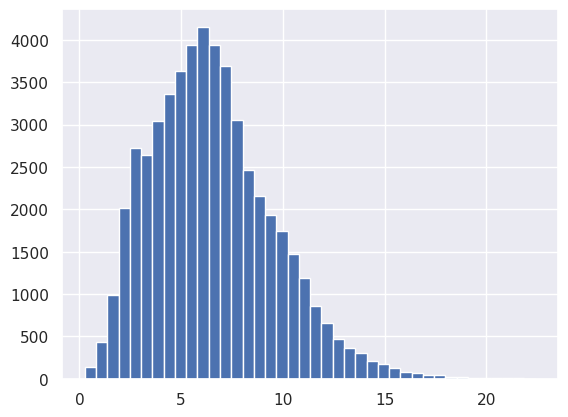

In [123]:
fig, ax = plt.subplots()

d = ax.hist(wt["Wind speed"], bins=40)

In [124]:
wt_1m = wt[(wt.index >= "2020-01-01") & (wt.index < "2020-02-01")]

ws = wt_1m[["Wind speed"]]

# Resample to hourly

vh = ws.resample("H").mean()

In [125]:
ws.isnull().sum() == 0, len(vh)

(Wind speed    False
 dtype: bool,
 744)

## Processing: Weibull fit

In order to transform the wind speed distribution to be more Normal, fit the current distribution as Weibull using Bayesian Inference. The resulting shape parameter, $\alpha$, will be used to perform the transformation.

In [126]:
idata_wb = fit_weibull(vh)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
Sampling: [y]


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

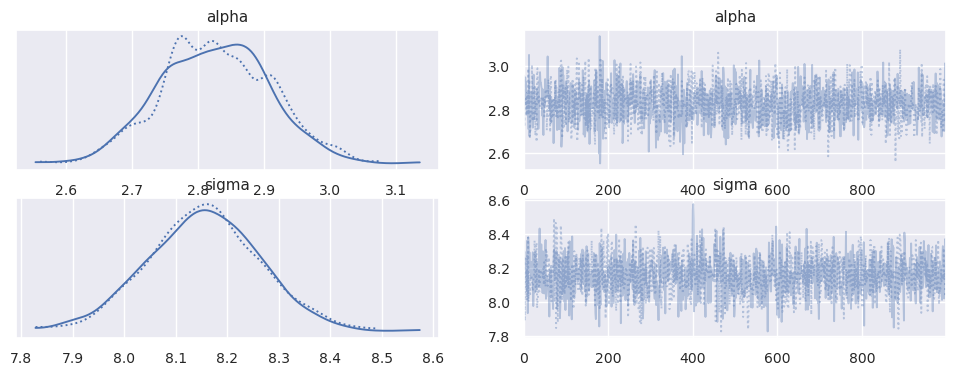

In [127]:
az.plot_trace(idata_wb)

In [128]:
az.loo(idata_wb)

Computed from 2000 posterior samples and 744 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1818.08    16.61
p_loo        1.98        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      744  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

<Axes: xlabel='y / y'>

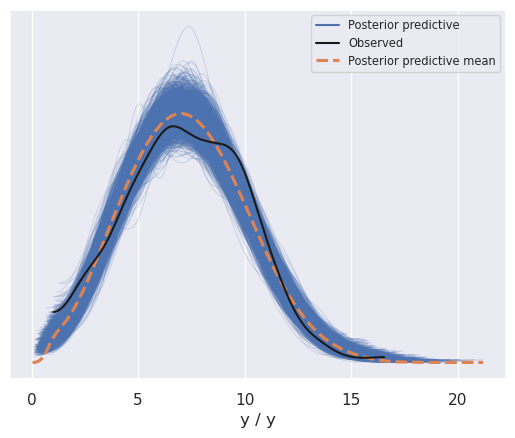

In [129]:
az.plot_ppc(idata_wb)

We can use the fitted Weibull distribution's shape parameter $\alpha$ to apply a transform to our wind speed data $V$ to make it more Gaussian,

$$
\hat{V} = V^m
$$

where

$$
m = \frac{\alpha}{3.6}
$$

Why 3.6? This is the shape parameter corresponding to a Weibull distribution with Gaussian shape.

In [130]:
shape = idata_wb.posterior.alpha.mean(["chain", "draw"]).item(0)
scale = idata_wb.posterior.sigma.mean(["chain", "draw"]).item(0)

m = shape / 3.6

print(f"m: {m}")

m: 0.7849768921498966


## Modeling

Autoregressive Moving Average (ARMA) models combine autoregression (AR) and moving average (MA) terms in order to best fit the time series. The ARMA(2, 2) model has been shown in the literature to be highly competitive for short-term wind speed forecasting, though other combinations of p (AR lags) and q (MA lags) may prove better depending on the situation.

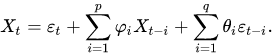

The data transformation includes both the scaling based on Weibull fit, as well as standardization based on mean/std wind speeds for given hours of the day, which helps remove diurnal nonstationarity.

In [131]:
v_tf, hr_stats = transform(vh, m, field="Wind speed")

v_tf.head()

,v,v_scaled,hr,v_scaled_std
Date,,,,
2020-01-01 00:00:00,3.867503,2.891475,0,-1.313151
2020-01-01 01:00:00,5.663008,3.900539,1,-0.555003
2020-01-01 02:00:00,4.896892,3.479939,2,-0.968128
2020-01-01 03:00:00,5.320999,3.714393,3,-0.868086
2020-01-01 04:00:00,4.438020,3.221281,4,-1.402173


Text(0.5, 0, 'std')

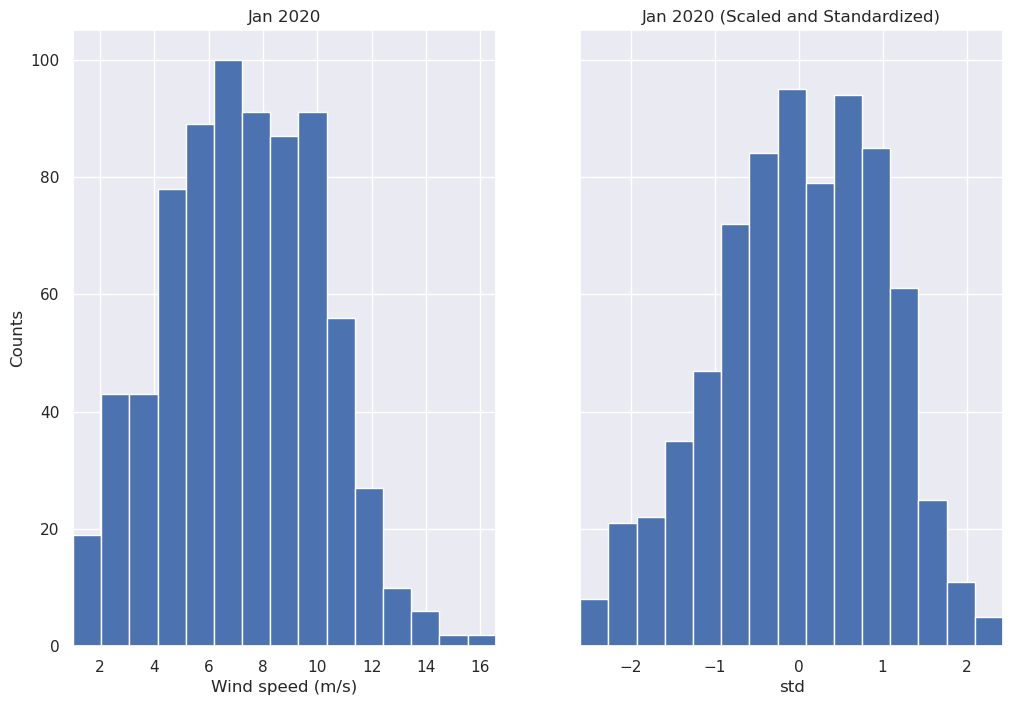

In [132]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8), sharey=True)

[ax.set_xmargin(0) for ax in axes]
axes[0].set_ylabel("Counts")
axes[0].hist(v_tf.v, bins=15)
axes[0].set_title("Jan 2020")
axes[0].set_xlabel("Wind speed (m/s)")
axes[1].hist(v_tf.v_scaled_std, bins=15)
axes[1].set_title("Jan 2020 (Scaled and Standardized)")
axes[1].set_xlabel("std")

In [133]:
arma_mod = ARIMA(v_tf.v_scaled_std, order=(2, 0, 2), trend="n")
arma_res = arma_mod.fit()
print(arma_res.summary())

                               SARIMAX Results                                
Dep. Variable:           v_scaled_std   No. Observations:                  744
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -223.594
Date:                Tue, 07 Mar 2023   AIC                            457.188
Time:                        19:57:47   BIC                            480.248
Sample:                    01-01-2020   HQIC                           466.077
                         - 01-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4084      0.240      1.702      0.089      -0.062       0.879
ar.L2          0.5138      0.223      2.301      0.021       0.076       0.952
ma.L1          0.5409      0.239      2.266      0.0

In [134]:
pred = arma_res.get_prediction().summary_frame()
pred.head()

v_scaled_std,mean,mean_se,mean_ci_lower,mean_ci_upper
Date,,,,
2020-01-01 00:00:00,0.000000,0.989457,-1.939299,1.939299
2020-01-01 01:00:00,-1.238995,0.327798,-1.881468,-0.596523
2020-01-01 02:00:00,-0.523352,0.327798,-1.165825,0.119120
2020-01-01 03:00:00,-0.974450,0.326823,-1.615013,-0.333888
2020-01-01 04:00:00,-0.758423,0.326541,-1.398432,-0.118414


Reverse the transformations for error calculations and plotting.

In [135]:
inv_df = inv_transform(pred, m, hr_stats)

In [136]:
rmse = mean_squared_error(v_tf.v, inv_df["mean"], squared=False)
print("RMSE:", rmse)

RMSE: 0.8954646664353183


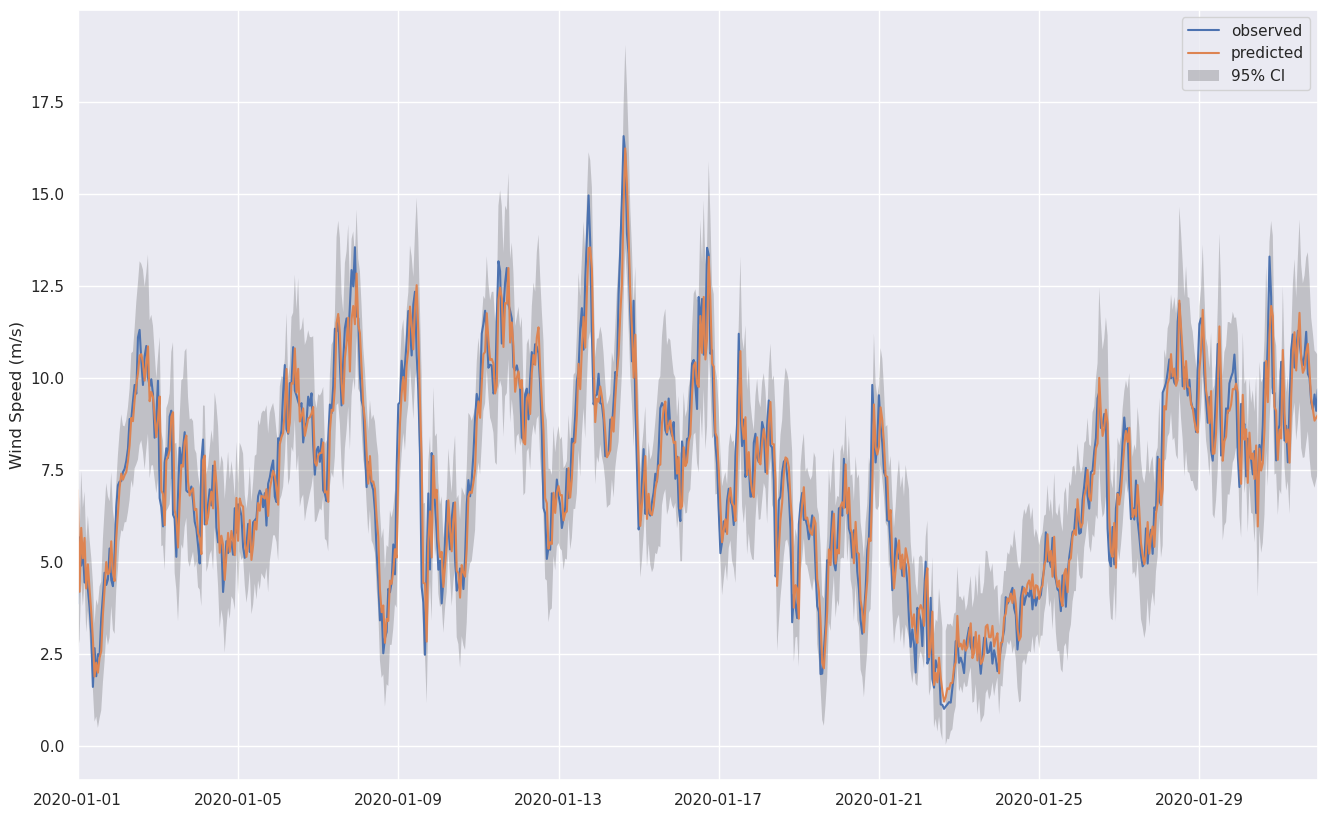

In [137]:
fig, ax = plt.subplots(figsize=(16, 10))

ax.set_xmargin(0)
ax.set_ylabel("Wind Speed (m/s)")

ax.plot(v_tf.index, v_tf.v, label="observed")

ax.plot(inv_df.index, inv_df["mean"], label="predicted")
ax.fill_between(
    inv_df.index, 
    inv_df.mean_ci_lower, 
    inv_df.mean_ci_upper, 
    color="k", alpha=.2, linewidth=0,
    label="95% CI"
)

ax.legend()


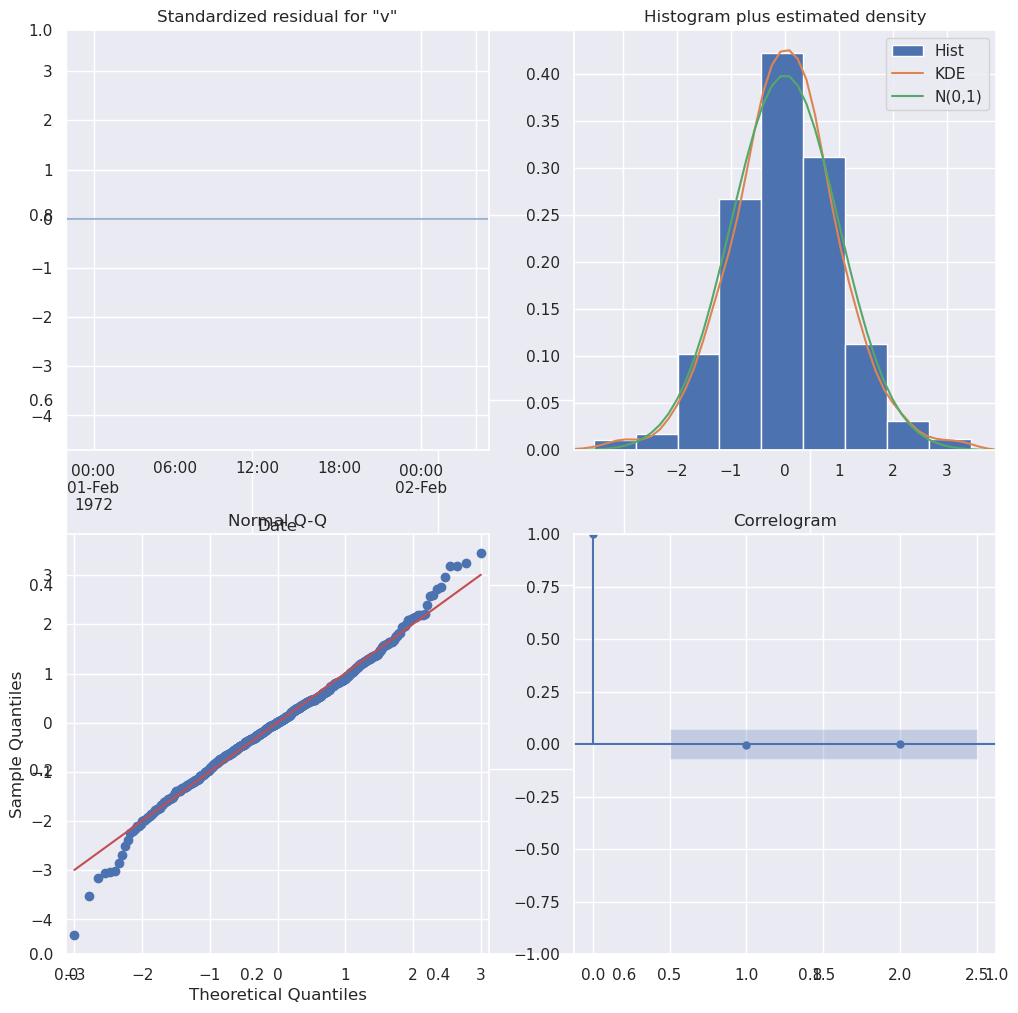

In [138]:
fig, ax = plt.subplots(figsize=(12, 12))

f = arma_res.plot_diagnostics(fig=fig, lags=2)

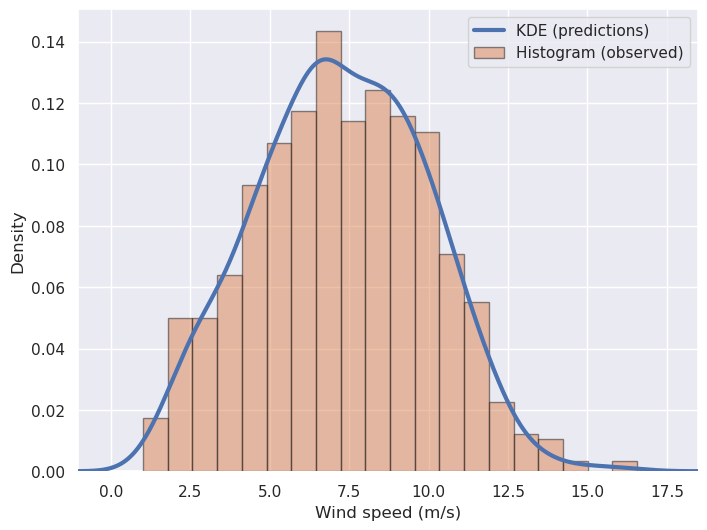

In [139]:
kde = sm.nonparametric.KDEUnivariate(inv_df["mean"])
kde.fit()  # Estimate the densities

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xmargin(0)
ax.set_xlabel("Wind speed (m/s)")
ax.set_ylabel("Density")

ax.plot(kde.support, kde.density, lw=3, label="KDE (predictions)", zorder=10)
ax.hist(
    v_tf.v,
    bins=20,
    density=True,
    label="Histogram (observed)",
    zorder=5,
    edgecolor="k",
    alpha=0.5,
)
ax.legend()

## Forecast

WIP

<Axes: >

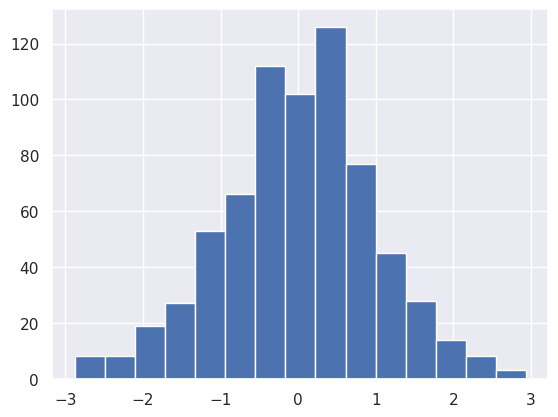

In [140]:
v_tf_test.v_scaled_std.hist(bins=15)

In [141]:
wt_test = wt[(wt.index >= "2020-02-01") & (wt.index < "2020-03-01")]

In [142]:
ws_test = wt_test[["Wind speed"]].resample("H").mean()
assert ws_test["Wind speed"].isnull().sum() == 0 # sanity check

v_tf_test, hr_stats = transform(ws_test, m, field="Wind speed")
v_tf_test

,v,v_scaled,hr,v_scaled_std
Date,,,,
2020-02-01 00:00:00,9.675224,5.939107,0,0.155474
2020-02-01 01:00:00,9.348447,5.781067,1,0.045450
2020-02-01 02:00:00,8.373743,5.302377,2,-0.228293
2020-02-01 03:00:00,9.559914,5.883472,3,0.055168
2020-02-01 04:00:00,10.035535,6.112040,4,0.095213
...,...,...,...,...
2020-02-29 19:00:00,14.725852,8.258785,19,1.319338
2020-02-29 20:00:00,13.464066,7.697988,20,1.002268
2020-02-29 21:00:00,12.270828,7.157162,21,0.800907


<Axes: xlabel='Date'>

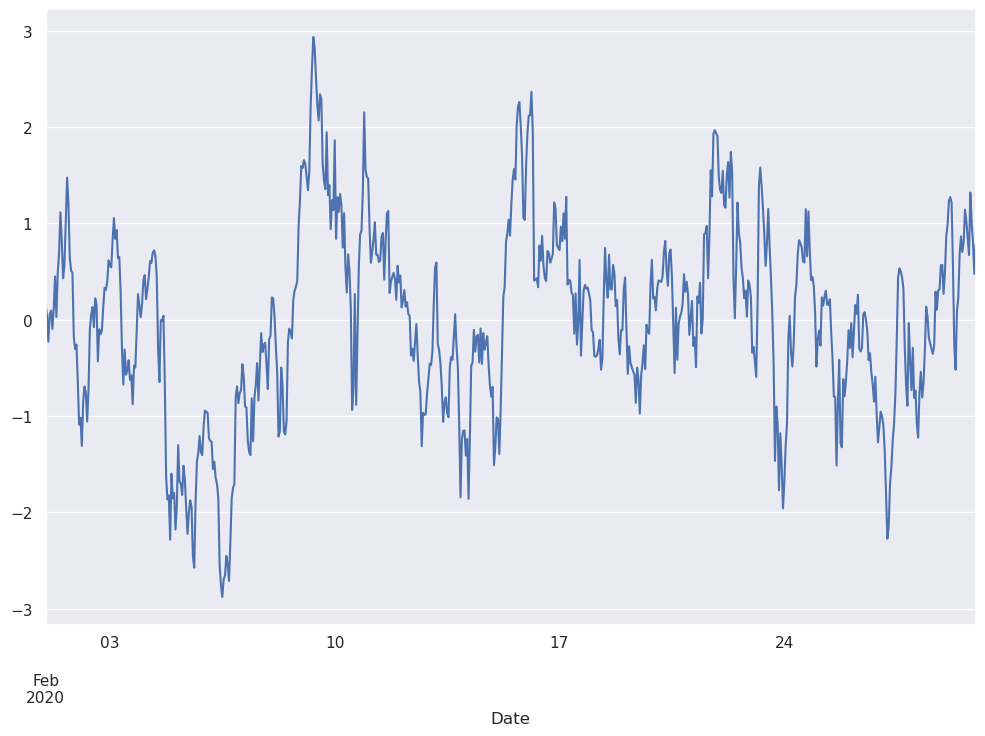

In [143]:
v_tf_test.v_scaled_std.plot(figsize=(12, 8))

In [144]:
forecast = arma_res.get_forecast(steps=4)
forecast_res = forecast.summary_frame()
forecast_res

v_scaled_std,mean,mean_se,mean_ci_lower,mean_ci_upper
2020-02-01 00:00:00,1.026203,0.326301,0.386665,1.665742
2020-02-01 01:00:00,0.949178,0.449913,0.067365,1.830992
2020-02-01 02:00:00,0.914915,0.523346,-0.110824,1.940653
2020-02-01 03:00:00,0.861344,0.588129,-0.291367,2.014055


In [146]:
# fig, ax = plt.subplots(figsize=(15, 5))

# forecast_res = forecast.summary_frame()
# v_12h = v_p[-12:]

# ax.plot(range(len(v_12h)), v_12h)
# forecast_res.index += 12

# forecast_res['mean'].plot(ax=ax, style='k--')
# ax.fill_between(forecast_res.index, forecast_res['mean_ci_lower'], forecast_res['mean_ci_upper'], color='k', alpha=0.1);